# $B^+ \to K^+ a(\to \mu^+\mu^-)$ at LHCb

In [61]:
from PIL import Image # Reading and manipulating images
import numpy as np # Math stuff
import matplotlib.pyplot as plt # Plot stuff
plt.rcParams.update({'font.size': 12, 'text.usetex': True, 'font.family': 'serif', 'font.serif': ['Computer Modern Roman']}) # Set font size and family
from scipy.interpolate import interp1d, RegularGridInterpolator # Interpolation

## Digitizing the image

[arXiv:1612.07818](https://arxiv.org/abs/1612.07818)

The image is converted to HSV color space, as the hue of each pixel encodes the BR.

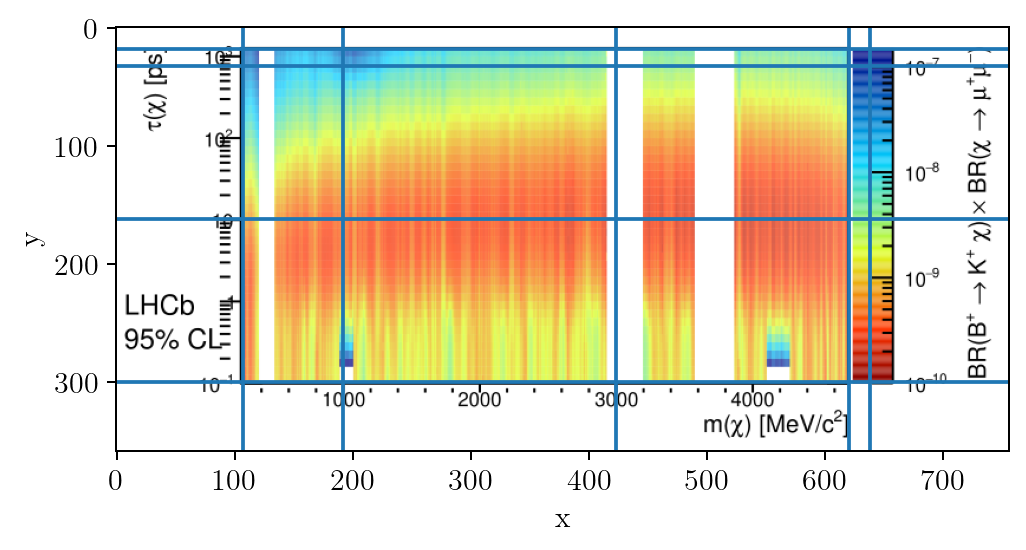

In [62]:
img = Image.open('LHCb_BKmumu.png')
imgH = img.convert('HSV')

plt.figure(dpi=180)
plt.imshow(np.asarray(img))
plt.xlabel('x')
plt.ylabel('y')
plt.axvline(638) #Vertical line along the colorbar
plt.axhline(300) # BR = 1e-10 in the colorbar, tau = 0.1ps
plt.axhline(32) # BR = 1e-7 in the colorbar
plt.axhline(18) #Upper limit in the colorbar, log(BR) = -7 + 14/(300-32)*3 = -6.841

plt.axvline(107) #Begining of the x-axis
plt.axvline(620) # End of the x-axis

plt.axvline(192) # ma = 1GeV
plt.axvline(423) # ma = 3GeV

plt.axhline(162) # tau = 10ps

In [63]:
cbar = {}
for iy, y in enumerate(range(17, 300)):
    cbar[imgH.getpixel((638, y))[0]] = np.linspace(-6.84, -10, 300-17)[iy]


The hue is a monotonical function of the BR, so we can invert it to read the BR of each pixel

Text(0, 0.5, 'Hue')

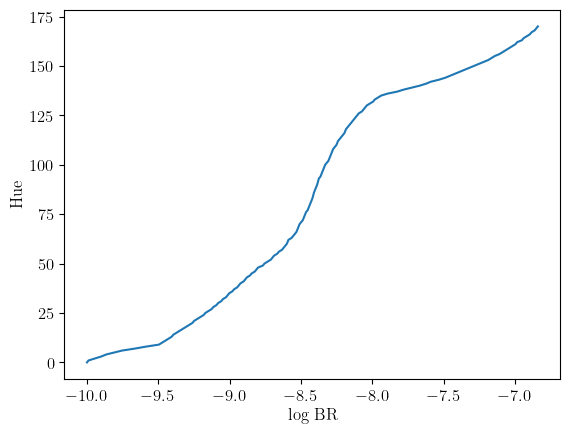

In [64]:
plt.plot(cbar.values(), cbar.keys())
plt.xlabel('log BR')
plt.ylabel('Hue')

In [65]:
interp_color = interp1d(list(cbar.keys()), list(cbar.values()), kind='cubic')

In [66]:
matrix_br = np.full((619-107, 300-19), np.nan)

for ix, x in enumerate(range(107, 619)):
    for iy, y in enumerate(range(19, 300)):
        if img.getpixel((x, y))[:3] != (255, 255, 255):
            hue = min(imgH.getpixel((x, y))[0], max(cbar.keys()))
            matrix_br[ix, iy] = interp_color(hue)

In [67]:
ma = (np.arange(107, 619)-192)/(423-192)*2+1
logtau = -1+(np.arange(19, 300)-300)/(162-300)*2
x_ma, y_logtau = np.meshgrid(ma, logtau)

/tmp/ipykernel_97618/919640329.py:2: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = plt.colorbar()


Text(0.5, 1.0, '95\\% CL upper limit at LHCb')

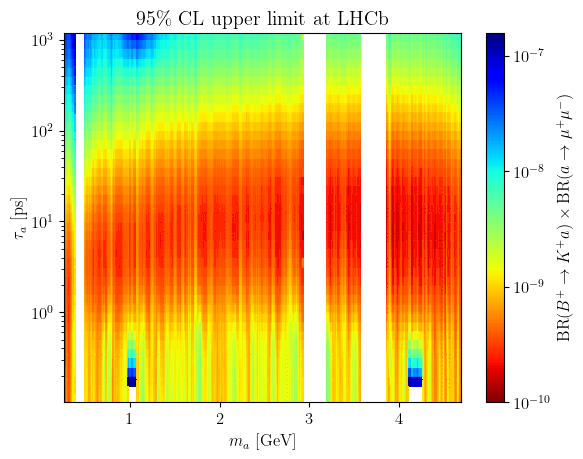

In [ ]:
plt.pcolor(x_ma, 10**y_logtau, matrix_br.T, cmap = 'jet_r', vmin=-10, vmax=-6.8)
cb = plt.colorbar()
cb.set_ticks([-10, -9, -8, -7])
cb.set_ticklabels([r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$'])
cb.set_label(r'$\mathrm{BR}(B^+\to K^+ a) \times \mathrm{BR}(a\to \mu^+\mu^-)$')
plt.xlabel(r'$m_a$ [GeV]')
plt.ylabel(r'$\tau_a$ [ps]')
plt.title(r'95\% CL upper limit at LHCb')
ax= plt.gca()
ax.set_yscale('log')

# Saving and loading

We save as a numpy array containing the grid of logarithms of the BR. The matrix is extended by one row and one column, containing the values of $m_a$ and $\log_{10}\tau_a$ respectively.

In [73]:
matrix_res = np.full((300-19+1, 619-107+1), np.nan)

for ix in range(matrix_br.shape[0]):
    for iy in range(matrix_br.shape[1]):
        if not np.isnan(matrix_br[ix, iy]):
            matrix_res[iy, ix] = matrix_br[ix, iy]

for ix in range(len(logtau)):
    matrix_res[ix, -1] = logtau[ix]

for iy in range(len(ma)):
    matrix_res[-1, iy] = ma[iy]

In [74]:
np.save('../../alpaca/experimental_data/visible/LHCb_BKmumu_displ.npy', matrix_res)

And we can load the matrix and retrieve all the data

In [75]:
m2 = np.load('../../alpaca/experimental_data/visible/LHCb_BKmumu_displ.npy')

In [76]:
ma = m2[-1,:-1]
logtau = m2[:-1,-1]
matrix_br = m2[:-1,:-1]
x_ma, y_logtau = np.meshgrid(ma, logtau)

/tmp/ipykernel_97618/2776747312.py:2: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = plt.colorbar()


Text(0.5, 1.0, '95\\% CL upper limit at LHCb')

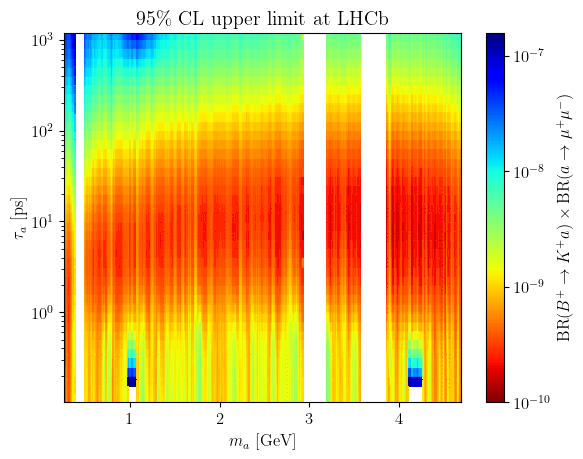

In [77]:
plt.pcolor(x_ma, 10**y_logtau, matrix_br, cmap = 'jet_r', vmin=-10, vmax=-6.8)
cb = plt.colorbar()
cb.set_ticks([-10, -9, -8, -7])
cb.set_ticklabels([r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$'])
ax= plt.gca()
ax.set_yscale('log')
cb.set_label(r'$\mathrm{BR}(B^+\to K^+ a) \times \mathrm{BR}(a\to \mu^+\mu^-)$')
plt.xlabel(r'$m_a$ [GeV]')
plt.ylabel(r'$\tau_a$ [ps]')
plt.title(r'95\% CL upper limit at LHCb')

## Interpolation

The interpolator already returns `NaN` for points with missing data, i.e. in the charmonium resonances. With the option `bounds_error=False`, it will also return `NaN` for values out of bounds.

In [78]:
interp_br = RegularGridInterpolator((ma, logtau), matrix_br.T, method='linear', bounds_error=False)

In [79]:
ma2 = np.linspace(0, 5.0, 500)
logtau2 = np.linspace(-1, 3.2, 500)
x_ma2, y_logtau2 = np.meshgrid(ma2, logtau2)
points = np.vstack([x_ma2.ravel(), y_logtau2.ravel()]).T

In [80]:
z_br = interp_br(points).reshape(x_ma2.shape)

/tmp/ipykernel_97618/4096416294.py:2: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = plt.colorbar()


Text(0.5, 1.0, '95\\% CL upper limit at LHCb')

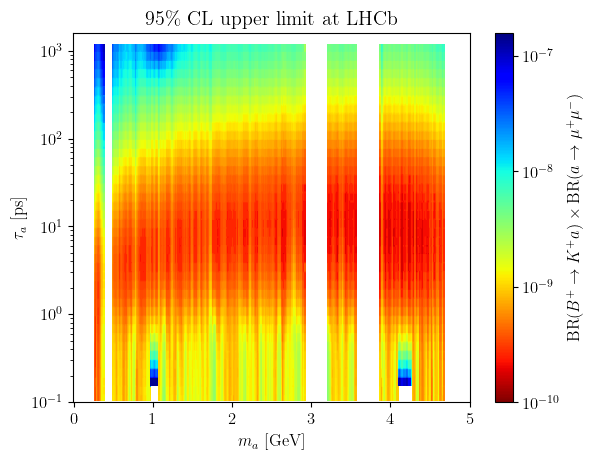

In [81]:
plt.pcolor(x_ma2, 10**y_logtau2, z_br, cmap = 'jet_r', vmin=-10, vmax=-6.8)
cb = plt.colorbar()
cb.set_ticks([-10, -9, -8, -7])
cb.set_ticklabels([r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$'])
ax= plt.gca()
ax.set_yscale('log')
cb.set_label(r'$\mathrm{BR}(B^+\to K^+ a) \times \mathrm{BR}(a\to \mu^+\mu^-)$')
plt.xlabel(r'$m_a$ [GeV]')
plt.ylabel(r'$\tau_a$ [ps]')
plt.title(r'95\% CL upper limit at LHCb')

Text(0.5, 1.0, '95\\% CL upper limit at LHCb')

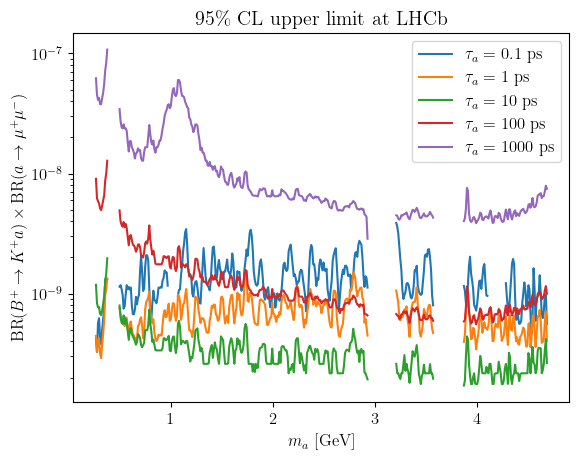

In [99]:
plt.semilogy(ma2, 10**interp_br((ma2, np.log10(0.104*np.ones_like(ma2)))).flatten(), label=r'$\tau_a = 0.1$ ps')
plt.semilogy(ma2, 10**interp_br((ma2, np.log10(1*np.ones_like(ma2)))).flatten(), label=r'$\tau_a = 1$ ps')
plt.semilogy(ma2, 10**interp_br((ma2, np.log10(10*np.ones_like(ma2)))).flatten(), label=r'$\tau_a = 10$ ps')
plt.semilogy(ma2, 10**interp_br((ma2, np.log10(100*np.ones_like(ma2)))).flatten(), label=r'$\tau_a = 100$ ps')
plt.semilogy(ma2, 10**interp_br((ma2, np.log10(1000*np.ones_like(ma2)))).flatten(), label=r'$\tau_a = 1000$ ps')
plt.legend()
plt.xlabel(r'$m_a$ [GeV]')
plt.ylabel(r'$\mathrm{BR}(B^+\to K^+ a) \times \mathrm{BR}(a\to \mu^+\mu^-)$')
plt.title(r'95\% CL upper limit at LHCb')